# Файл titanicdf.csv, задачи:


1. Предобработать данные (пропуски, замена текста, дубликаты и т.д)
2. Использовать для классификации sklearn.ensemble.RandomForestClassifier
3. Подобрать лучшие гиперпараметры (n_estimators, criterion, max_depth)
4. Провести кроссвалидацию модели
5. Оценить метрики бинарной классификации (Precision, recall, f1)
6. Построить ROC-кривую для оценки качества классификатора

In [2]:
!pip install pymorphy2

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=c168754d048909cf74fc2e22801e791c7c153d87146b27708cd988c5e84f0dce
  Stored in directory: c:\users\usernc\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [35]:
import pandas as pd
import re
import numpy as np
import pymorphy2
import matplotlib.pyplot as plt

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,auc, fbeta_score

In [37]:
df = pd.read_csv('titanicdf.csv')

1.Предобработать данные (пропуски, замена текста, дубликаты и т.д)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [39]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
df.Embarked.value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

In [41]:
df.Pclass.value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

<AxesSubplot:ylabel='Frequency'>

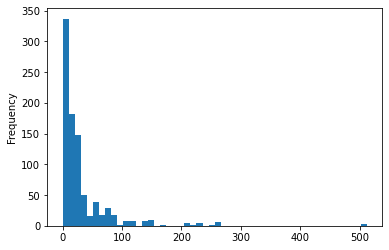

In [42]:
df.Fare.plot(kind='hist',bins=50)

In [43]:
for col in df.columns:
  print(col, round(df[col].isna().sum() / df.shape[0] *100,2))

PassengerId 0.0
Survived 0.0
Pclass 0.0
Name 0.0
Sex 0.0
Age 19.87
SibSp 0.0
Parch 0.0
Ticket 0.0
Fare 0.0
Cabin 77.1
Embarked 0.22


In [44]:
df.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [45]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [46]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [47]:
new_df = pd.get_dummies(data=df, columns=['Pclass', 'Sex','Embarked'])

In [48]:
new_df

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,0,1,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,1,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,1,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,0,1,0,0,1,0,0,1
887,888,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,1,0,0,1,0,0,0,1
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,0,0,1,1,0,0,0,1
889,890,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,1,0,0,0,1,1,0,0


In [49]:
df.duplicated().sum()

0

In [50]:
df.drop_duplicates(inplace=True)

In [51]:
df.dropna(inplace=True)

<AxesSubplot:ylabel='Frequency'>

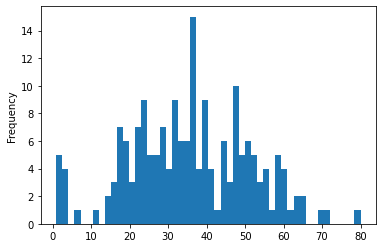

In [52]:
df.Age.plot(kind='hist',bins=50)

In [53]:
def check_age_for_molodezh(df):
  if df.Age <= 35:
    return 1
  else:
    return 0

In [54]:
def check_age_for_ten_years(df):
  return df.Age // 10 * 10

In [55]:
35 // 10

3

In [56]:
df['youth'] = df.apply(check_age_for_molodezh,axis=1)

In [57]:
df['youth_10'] = df.apply(check_age_for_ten_years,axis=1)

In [58]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,youth,youth_10
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,30.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,30.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,50.0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,1,0.0
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S,0,40.0
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S,1,30.0
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C,0,50.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,10.0


In [65]:
titanic_df = df[['Survived','Pclass','Age','Fare']]

In [66]:
titanic_df

,Survived,Pclass,Age,Fare
1,1,1,38.0,71.2833
3,1,1,35.0,53.1000
6,0,1,54.0,51.8625
10,1,3,4.0,16.7000
11,1,1,58.0,26.5500
...,...,...,...,...
871,1,1,47.0,52.5542
872,0,1,33.0,5.0000
879,1,1,56.0,83.1583
887,1,1,19.0,30.0000


2. Использовать для классификации sklearn.ensemble.RandomForestClassifier

In [67]:
clf = RandomForestClassifier()

In [68]:
x_train, x_test, y_train, y_test = train_test_split(titanic_df.drop('Survived',axis=1), df['Survived'], test_size=0.2, random_state=200)
df['Survived']

1      1
3      1
6      0
10     1
11     1
      ..
871    1
872    0
879    1
887    1
889    1
Name: Survived, Length: 183, dtype: int64

In [69]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [70]:
x_train.shape

(146, 3)

In [71]:
x_test.shape

(37, 3)

In [72]:
pred = clf.predict(x_test)

In [73]:
print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.7297297297297297
Precision: 0.7333333333333333
Recall: 0.9166666666666666
F1: 0.8148148148148148


3. Подобрать лучшие гиперпараметры (n_estimators, criterion, max_depth)

In [75]:
params = {'criterion':['gini','entropy'],
          'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
          'n_estimators':[1,2,3,4,5,6,7,8,9,10]}

In [76]:
test_params = pd.DataFrame(test_params, columns=['n_estimators', 'max_depth', 'criterion', 'f1_score', 'recall_score'])
test_params.sort_values(by='f1_score', ascending=False).head(5)

,n_estimators,max_depth,criterion,f1_score,recall_score


In [78]:
clf_gs = GridSearchCV(RandomForestClassifier(), params)
clf_gs.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [79]:
clf_gs.best_params_

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 10}

Модель с подобранными параметрами

In [80]:
new_rfc = RandomForestClassifier(**clf_gs.best_params_)
new_rfc.fit(x_train, y_train) 

RandomForestClassifier(max_depth=5, n_estimators=10)

In [81]:
new_pred = new_rfc.predict(x_test)

In [82]:
print('Accuracy:',accuracy_score(y_test,new_pred))
print('Precision:',precision_score(y_test,new_pred))
print('Recall:',recall_score(y_test,new_pred))
print('F1:',f1_score(y_test,new_pred))

Accuracy: 0.7837837837837838
Precision: 0.7666666666666667
Recall: 0.9583333333333334
F1: 0.8518518518518519


4. Провести кроссвалидацию модели

In [85]:
cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
scores = cross_val_score(new_rfc, x_train, y_train, cv=cv, scoring='recall')
scores.mean()

0.8757610258179518

In [86]:
scores

array([0.88571429, 0.90322581, 0.91176471, 0.78787879, 0.87878788,
       0.82857143, 0.83333333, 0.88571429, 0.93939394, 0.90322581])

5. Оценить метрики бинарной классификации (Precision, recall, f1)
Модель с подобранными параметрами

In [88]:
print('Accuracy:',accuracy_score(y_test,new_pred))
print('Precision:',precision_score(y_test,new_pred))
print('Recall:',recall_score(y_test,new_pred))
print('F1:',f1_score(y_test,new_pred))

Accuracy: 0.7837837837837838
Precision: 0.7666666666666667
Recall: 0.9583333333333334
F1: 0.8518518518518519


Модель с дефолтными параметрами

In [89]:
print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.7297297297297297
Precision: 0.7333333333333333
Recall: 0.9166666666666666
F1: 0.8148148148148148


6. Построить ROC-кривую для оценки качества классификатора

In [94]:
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=1, n_estimators=10)

In [95]:
clf.predict(x_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [99]:
clf.predict_proba(x_test)[:,1]

array([0.69147025, 0.71882152, 0.72203748, 0.72203748, 0.69147025,
       0.72203748, 0.69147025, 0.51944013, 0.69147025, 0.69147025,
       0.69147025, 0.72203748, 0.72203748, 0.72203748, 0.65749799,
       0.69147025, 0.69147025, 0.69147025, 0.69147025, 0.69147025,
       0.69147025, 0.65749799, 0.72203748, 0.72203748, 0.69147025,
       0.69147025, 0.69147025, 0.69147025, 0.69147025, 0.69147025,
       0.69147025, 0.69147025, 0.72203748, 0.69147025, 0.69147025,
       0.69147025, 0.69147025])

In [100]:
pred_proba = clf.predict_proba(x_test)[:,1]

In [101]:
fpr, tpr, treshold = roc_curve(y_test, pred_proba)
tree_auc = roc_auc_score(y_test, pred_proba)
print(f'RandomForestClassifier: ROC AUC={round(tree_auc,2)}')

RandomForestClassifier: ROC AUC=0.58


In [102]:
fpr, tpr, treshold = roc_curve(y_test, pred_proba)
forest_auc = roc_auc_score(y_test, pred_proba)
print('RandomForestClassifier: ROC AUC=%.3f' % (forest_auc))

RandomForestClassifier: ROC AUC=0.575


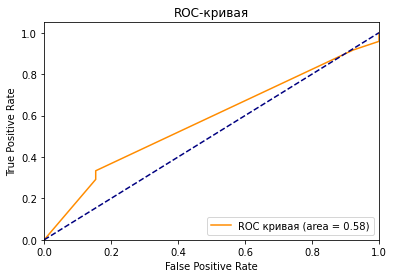

In [103]:
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,  color='darkorange',
         label=f'ROC кривая (area = {round(roc_auc, 2)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right") 
plt.show()